In [17]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import subprocess
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier
import subprocess

In [ ]:
# Código para garantir que o nome de cada arquivo de imagem seja um número inteiro e
# que os números sigam uma sequencia monotonica iniciando em 1
# o diretório relativo a letra T possuía problemas com os nomes de algumas imagens
# NÂO é necessário executar o código dessa célula, a menos que o conjunto de dados 
# com os nomes originais seja usado
lista_de_arquivos = []
for nome_do_arquivo in os.listdir('imagens/train/T'):
         if os.path.isfile(os.path.join('imagens/train/T', nome_do_arquivo)):
             lista_de_arquivos.append(nome_do_arquivo)
lista_de_arquivos.sort()
indice_inicial = 413
for i in range(indice_inicial, len(lista_de_arquivos)):
    nome_atual = f'./imagens/train/T/{lista_de_arquivos[i]}'
    novo_indice = i + 1
    nome_novo = f'./imagens/train/T/{novo_indice}.png'
    os.rename(nome_atual, nome_novo)

In [18]:
# Lista com nome de todos os diretórios
label = ["A","B","C","D","E","F","G","I","L","M","N","O","P","Q","R","S","T","U","V","W"]

# Landmarks: 
* WRIST
* THUMB_CMC
* THUMB_MCP
* THUMB_IP
* THUMB_TIP
* INDEX_FINGER_MCP
* INDEX_FINGER_PIP
* INDEX_FINGER_DIP
* INDEX_FINGER_TIP
* MIDDLE_FINGER_MCP
* MIDDLE_FINGER_PIP
* MIDDLE_FINGER_DIP
* MIDDLE_FINGER_TIP
* RING_FINGER_MCP
* RING_FINGER_PIP
* RING_FINGER_DIP
* RING_FINGER_TIP
* PINKY_MCP
* PINKY_PIP
* PINKY_DIP
* PINKY_TIP


In [4]:
def imagem_para_lista_de_coordenadas(nome_csv, caminho_imagem, tipo, tecnica, hands):
    try:
        image = cv2.imread(caminho_imagem)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Processando a imagem com o MediaPipe Hands
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            if(tecnica == "centro_geometrico"):
                results = results.multi_hand_world_landmarks
            else:
                results = results.multi_hand_landmarks
            for hand_landmarks in results:
                # Print the coordinates of the landmarks
                for landmark in hand_landmarks.landmark:
                    newRow.append(landmark.x)
                    newRow.append(landmark.y)
                    newRow.append(landmark.z)
            newRow = []
            return newRow
        else:
            
            return None
    except Exception as e:
        return None
    


In [5]:
def contar_arquivos(caminho_repositorio):
    count_subprocess_result = subprocess.run(f'find {caminho_repositorio} -type f | wc -l', stdout=subprocess.PIPE, shell=True, text=True)
    output = count_subprocess_result.stdout.strip()
    return int(output)

In [13]:
# tipo = <train|test>
# tecnica=<centro_geometrico, normalizado>
# ATENÇÃO: o código assume a existência de diretorios destinados as imagens 
# as quais o mediapipe não foi capaz de extrair as landmarks
# nomeados como imagens_com_problemas_{tipo}_{tecnica}

def gerador_de_csv_com_as_coordenadas_e_os_rotulos(tipo, tecnica):
    # Obtendo o numero de arquivos de imagem de cada letra
    # Lista com nome de todos os diretórios
    label = ["A","B","C","D","E","F","G","I","L","M","N","O","P","Q","R","S","T","U","V","W"]
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    num_files = []# cada elemento da lista é o numero de arquivos de imagem das letras em ordem alfabética
    for i,reps in enumerate(label):
        # Caminho do diretório
        directory = f'./imagens/{tipo}/{reps}'
        num_files.append(contar_arquivos(directory))
    
    csv_filename = f'{tipo}_{tecnica}.csv'
    header = [f'Landmark{i}_{axis}' for i in range(0, 21) for axis in ['x', 'y', 'z']]
    header.append('label')
    
    command = f'rm -rf ./imagens_com_problemas_{tipo}_{tecnica}/*',
    subprocess.run(command, shell=True, check=True)

    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header) # Inserindo os nomes dos atributos
        for i, reps in enumerate(label): 
            for j in range(1,num_files[i]+1):

                # Outro problema com os nomes
                if(reps == 'F' and j > 300 and tipo == 'test'):
                    k = j + 100
                else:
                    k = j

                caminho = f"imagens/{tipo}/{reps}/{k}.png"

                lista_de_coordenadas = imagem_para_lista_de_coordenadas(csv_filename, caminho, tipo, tecnica, hands)
                if lista_de_coordenadas is not None:
                    lista_de_coordenadas.append(reps)
                    writer.writerow(lista_de_coordenadas)
                else:
                    try:
                        image = cv2.imread(caminho)
                        cv2.imwrite(f"imagens_com_problemas_{tipo}_{tecnica}/imagem{reps}00{k}.png", image)
                    except Exception as e:
                        print(caminho)

In [14]:
gerador_de_csv_com_as_coordenadas_e_os_rotulos('test', 'normalizado')

W0000 00:00:1718414590.400296   59851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718414590.420973   59850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [ ]:
df_train = pd.read_csv('treino_centro_geometrico.csv')
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']


In [8]:
df_test = pd.read_csv('test_centro_geometrico.csv')
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100, 100), random_state=1, max_iter = 10000)


In [ ]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=10000,
              random_state=1, solver='lbfgs')

In [ ]:
df_test = pd.read_csv('test_centro_geometrico.csv')

In [ ]:
results = clf.predict(X_test)

In [ ]:
df_results_compare = pd.DataFrame(results == y_test)
df_results_compare['label'].value_counts()
    

label
True     10852
False       29
Name: count, dtype: int64

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Parâmetros
image_size = (64, 64)  
batch_size = 32
epochs = 20

# Caminhos para os dados
train_data_dir = 'imagens/train/'
test_data_dir = 'imagens/test/'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 33064 images belonging to 20 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10998 images belonging to 20 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  

# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,780 (2.62 MB)

 Trainable params: 685,780 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinamento do modelo
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    verbose=1
)

Epoch 1/20


C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 268s 256ms/step - accuracy: 0.4727 - loss: 1.6856
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.9062 - loss: 0.3961 
Epoch 3/20


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.9127 - loss: 0.2488
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.9375 - loss: 0.2314  
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.9431 - loss: 0.1605
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.9375 - loss: 0.1358  
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.9598 - loss: 0.1101
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.9375 - loss: 0.1021  
Epoch 9/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.9701 - loss: 0.0849
Epoch 10/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.9375 - loss: 0.0572  
Epoch 11/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step - accuracy: 0.9774 - loss: 0.0651
Epoch 12/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.9375 - loss: 0.1298  
Epoch 13/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.9793 - loss: 0.0602
Epoch 14/20
1033/

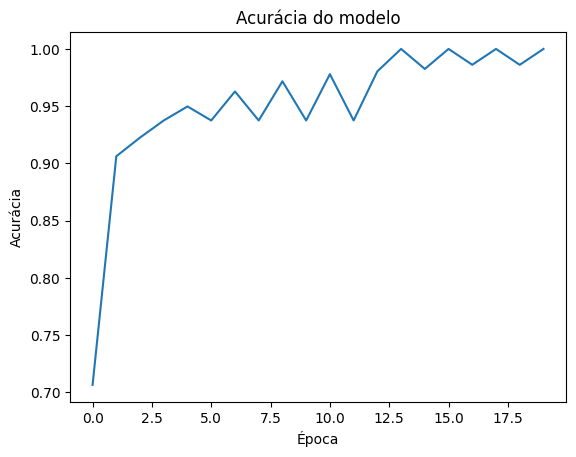

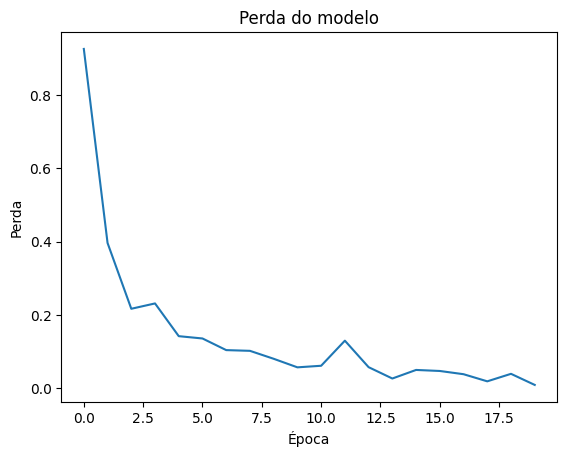

In [ ]:
import matplotlib.pyplot as plt

# Plotando a acurácia
plt.plot(history.history['accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.show()

# Plotando a perda
plt.plot(history.history['loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.show()


In [14]:
# Avaliação do modelo
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_acc)

# Mapeamento das classes
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Exemplo de uma previsão
img_path = 'imagens/test/A/1.png'  # Exemplo de caminho da imagem
img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Obter o nome da classe prevista
classes = list(class_indices.keys())
predicted_label = classes[predicted_class]
print("Predicted Label:", predicted_label)


343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9734 - loss: 0.1214
Acurácia no conjunto de teste: 0.9733054041862488
Class Indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'I': 7, 'L': 8, 'M': 9, 'N': 10, 'O': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'U': 17, 'V': 18, 'W': 19}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Label: A
